In [1]:
import scprep, phate
#dbio

import os

#import sys
#sys.path.append('/home/dan/burkhardt/software/AAnet/')

import AAnet
import network
import numpy as np
import AAtools
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf
import time
import pickle
from sklearn.decomposition import PCA
from scipy.spatial import procrustes
from sklearn.manifold import MDS
%load_ext autoreload
%autoreload 2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [4]:
basedir = '/data/lab/DataSets/Ryan-TILs/10x-t17010/5prime'
#samples = ['062418_TILD0UNSEL', '062418_TILD14PD1NEG', '062418_TILD14PD1POS']
sample = '062418_TILD0UNSEL'
suffix  = 'outs/filtered_gene_bc_matrices/GRCh38/'
data_raw = scprep.io.load_10X(os.path.join(basedir, sample, suffix), gene_labels='both', sparse=False)

In [5]:
data_raw

,RP11-34P13.3 (ENSG00000243485),FAM138A (ENSG00000237613),OR4F5 (ENSG00000186092),RP11-34P13.7 (ENSG00000238009),RP11-34P13.8 (ENSG00000239945),RP11-34P13.14 (ENSG00000239906),RP11-34P13.9 (ENSG00000241599),FO538757.3 (ENSG00000279928),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),...,AC007325.2 (ENSG00000277196),BX072566.1 (ENSG00000277630),AL354822.1 (ENSG00000278384),AC023491.2 (ENSG00000278633),AC004556.1 (ENSG00000276345),AC233755.2 (ENSG00000277856),AC233755.1 (ENSG00000275063),AC240274.1 (ENSG00000271254),AC213203.1 (ENSG00000277475),FAM231B (ENSG00000268674)
0,,,,,,,,,,,,,,,,,,,,,
AAACCTGCATCTACGA-1,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGGTAGAGGAA-1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGGTCTCATCC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGTCTAACGGT-1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
AAACCTGTCTTTCCTC-1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
AAACGGGGTGGTCTCG-1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
AAACGGGGTTTACTCT-1,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
AAACGGGTCAAACCAC-1,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
AAAGATGAGGATGGTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data_norm = scprep.filter.remove_rare_genes(data_raw, min_cells=10)

In [7]:
libsize = data_norm.sum(axis=1)

In [8]:
data_norm = scprep.filter.filter_library_size(data_norm, cutoff=50000, keep_cells='below')

In [9]:
data_norm = scprep.normalize.library_size_normalize(data_norm)

In [10]:
mito_genes = scprep.utils.get_gene_set(data_norm, starts_with='MT-')

mito_expression = data_norm['MT-CO1 (ENSG00000198804)']

In [11]:
data_norm = scprep.filter.filter_values(data_norm, mito_expression, percentile=95, keep_cells='below')

In [12]:
data_norm = scprep.transform.sqrt(data_norm)

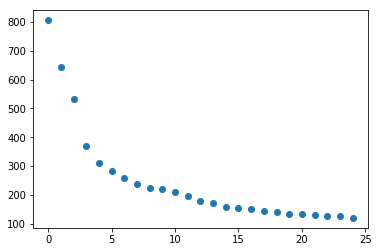

In [13]:
pc, X_mu, U, S = AAnet.AAnet.pcasvd([], data_norm.values, k=25)
plt.scatter(range(25), S)

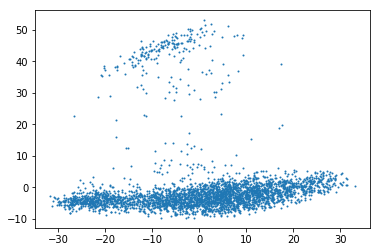

In [14]:
# plot PCA
plt.scatter(pc[:,0], pc[:,1], s=1)
plt.show()

In [15]:
sigma = np.std(pc[:,0])
pc_norm = pc / sigma
data = pc_norm

In [16]:
np.std(data, axis=0)

array([1.        , 0.79669432, 0.66022275, 0.45740461, 0.38508466,
       0.34976178, 0.32010047, 0.29491941, 0.27776051, 0.27341182,
       0.25904918, 0.24411722, 0.21998913, 0.21398266, 0.19778155,
       0.19230034, 0.18590108, 0.17831126, 0.17596866, 0.16737535,
       0.1641367 , 0.16259254, 0.15802976, 0.15558673, 0.14921691])

In [17]:
phate_op = phate.PHATE(n_pca=25, gamma=0, n_jobs=16)
Y_phate = phate_op.fit_transform(data)

Calculating PHATE...
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.62 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 0.67 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.20 seconds.
    Calculating KMeans...
    Calculated KMeans in 15.77 seconds.
  Calculated landmark operator in 17.17 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 0.77 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.30 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 25.21 seconds.
Calculated PHATE in 44.12 seconds.


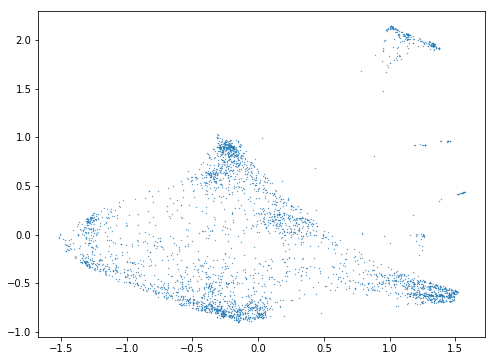

In [18]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.scatter(Y_phate[:,0], Y_phate[:,1], s=.1)
plt.show()

In [19]:
# AAnet params
num_at = 7
noise_z_std = 0.1
z_dim = [256, 128, 64]
#z_dim = [] # linear AA
#act_out = tf.nn.tanh
act_out = None # linear last layer
input_dim = data.shape[1]

In [20]:
# AAnet
enc_net = network.Encoder(num_at=num_at, z_dim=z_dim)
dec_net = network.Decoder(x_dim=input_dim, noise_z_std=noise_z_std, z_dim=z_dim, act_out=act_out)
model = AAnet.AAnet(enc_net, dec_net)

In [21]:
idx = None

In [22]:
model.train(data, batch_size=1024, num_batches=10000)

Iter [       0] Time [0.3097] loss [1.9885]
Iter [     500] Time [2.3931] loss [0.0305]
Iter [    1000] Time [4.3842] loss [0.0383]
Iter [    1500] Time [6.4382] loss [0.0250]
Iter [    2000] Time [8.4615] loss [0.0245]
Iter [    2500] Time [10.5067] loss [0.0268]
Iter [    3000] Time [12.5583] loss [0.0229]
Iter [    3500] Time [14.6164] loss [0.0224]
Iter [    4000] Time [16.6722] loss [0.0235]
Iter [    4500] Time [18.6933] loss [0.0233]
Iter [    5000] Time [20.7264] loss [0.0218]
Iter [    5500] Time [22.7578] loss [0.0216]
Iter [    6000] Time [24.7851] loss [0.0214]
Iter [    6500] Time [26.8090] loss [0.0216]
Iter [    7000] Time [28.8153] loss [0.0232]
Iter [    7500] Time [30.8547] loss [0.0210]
Iter [    8000] Time [32.8774] loss [0.0215]
Iter [    8500] Time [34.9024] loss [0.0239]
Iter [    9000] Time [36.9222] loss [0.0206]
Iter [    9500] Time [38.9451] loss [0.0202]
Iter [    9999] Time [40.8271] loss [0.0205]
done.


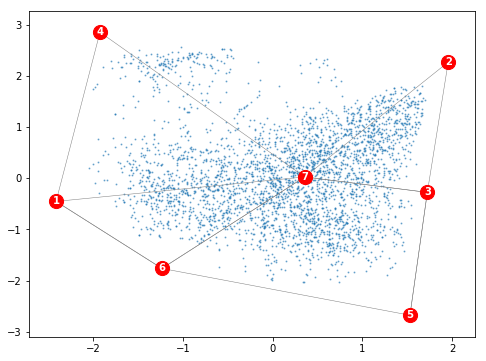

In [23]:
model.plot_at_mds(data)

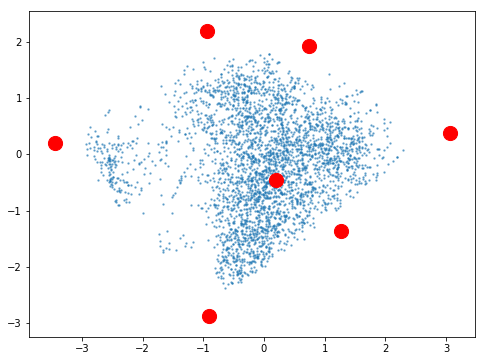

In [118]:
# MDS on z
ats_x = model.get_ats_x()
data_at = model.data2at(data)
embedding = MDS(n_components=2)
Y_mds_ats = embedding.fit_transform(ats_x)
Y_mds_data = data_at @ Y_mds_ats

fig = plt.figure(figsize=(8, 6))
plt.scatter(Y_mds_data[:,0], Y_mds_data[:,1], s=2, alpha=0.5, c=idx)
plt.scatter(Y_mds_ats[:,0], Y_mds_ats[:,1], s=200, alpha=1, c='r')
plt.show()

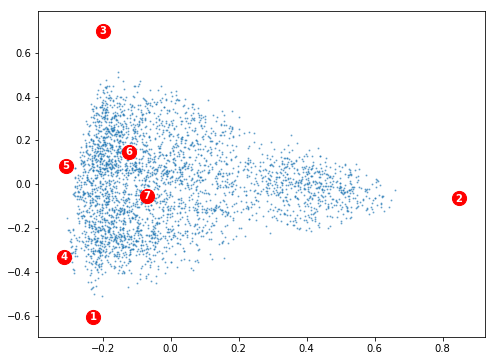

In [26]:
model.plot_at_pca_single(data)

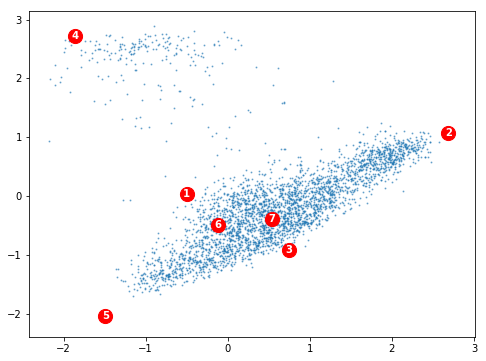

In [27]:
model.plot_pca_ats_data(data)

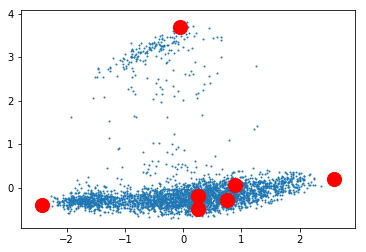

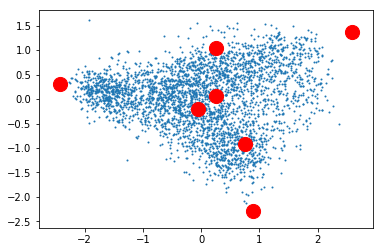

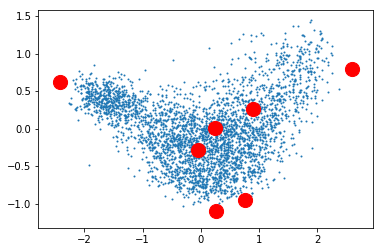

In [28]:
# plot original PCA with ATs
ats_x = model.get_ats_x()
plt.scatter(data[:,0], data[:,1], s=1, c=idx)
plt.scatter(ats_x[:,0], ats_x[:,1], s=200, alpha=1, c='r')
plt.show()
plt.scatter(data[:,0], data[:,2], s=1, c=idx)
plt.scatter(ats_x[:,0], ats_x[:,2], s=200, alpha=1, c='r')
plt.show()
plt.scatter(data[:,0], data[:,3], s=1, c=idx)
plt.scatter(ats_x[:,0], ats_x[:,3], s=200, alpha=1, c='r')
plt.show()

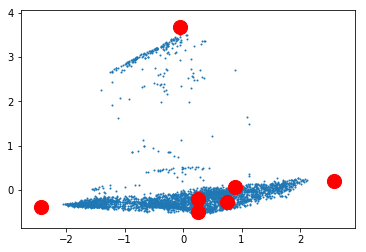

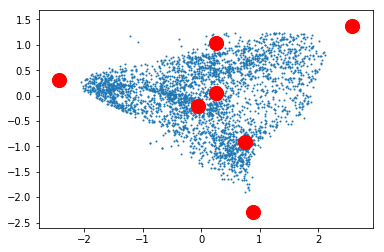

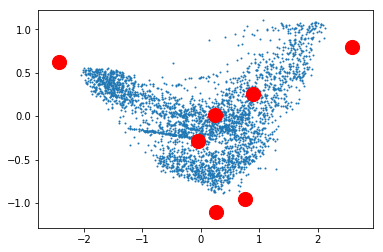

In [29]:
# plot PCA on reconstruction with ATs
ats_x = model.get_ats_x()
data_recon = model.at2data(model.data2at(data))
plt.scatter(data_recon[:,0], data_recon[:,1], s=1, c=idx)
plt.scatter(ats_x[:,0], ats_x[:,1], s=200, alpha=1, c='r')
plt.show()
plt.scatter(data_recon[:,0], data_recon[:,2], s=1, c=idx)
plt.scatter(ats_x[:,0], ats_x[:,2], s=200, alpha=1, c='r')
plt.show()
plt.scatter(data_recon[:,0], data_recon[:,3], s=1, c=idx)
plt.scatter(ats_x[:,0], ats_x[:,3], s=200, alpha=1, c='r')
plt.show()

In [41]:
# add archetypes to data
ats_x = model.get_ats_x()
data_nu = np.concatenate([data, ats_x])

In [42]:
data_nu.shape

(3341, 25)

In [43]:
phate_op = phate.PHATE(n_pca=25, gamma=0, n_jobs=16)
Y_phate_nu = phate_op.fit_transform(data_nu)

    Calculating PHATE...
    Calculating graph and diffusion operator...
      Calculating KNN search...
      Calculated KNN search in 0.62 seconds.
      Calculating affinities...
      Calculated affinities in 0.07 seconds.
    Calculated graph and diffusion operator in 0.70 seconds.
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 0.24 seconds.
      Calculating KMeans...
      Calculated KMeans in 13.75 seconds.
    Calculated landmark operator in 15.35 seconds.
    Calculating optimal t...
      Automatically selected t = 35
    Calculated optimal t in 0.74 seconds.
    Calculating diffusion potential...
    Calculated diffusion potential in 0.35 seconds.
    Calculating metric MDS...
  Calculated metric MDS in 27.68 seconds.
Calculated PHATE in 44.83 seconds.


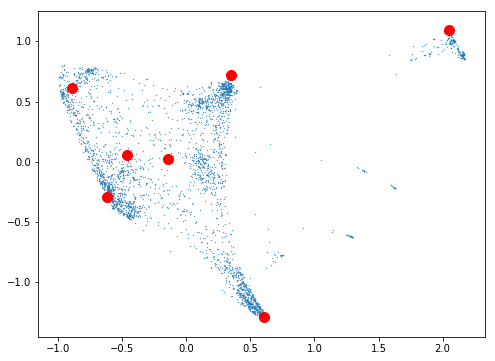

In [44]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.scatter(Y_phate_nu[:-num_at,0], Y_phate_nu[:-num_at,1], s=.1)
plt.scatter(Y_phate_nu[-num_at:,0], Y_phate_nu[-num_at:,1], s=100, c='r')
plt.show()

In [45]:
phate_op = phate.PHATE(n_pca=None, gamma=0, n_jobs=16, n_components=3)
Y_phate_nu_3D = phate_op.fit_transform(data_nu)

Calculating PHATE...
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.62 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 0.70 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.25 seconds.
    Calculating KMeans...
    Calculated KMeans in 14.10 seconds.
  Calculated landmark operator in 15.56 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 0.79 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.33 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 31.60 seconds.
Calculated PHATE in 49.00 seconds.


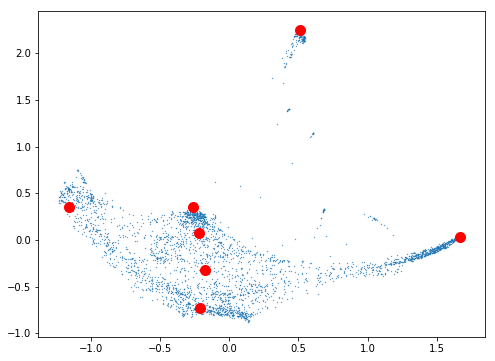

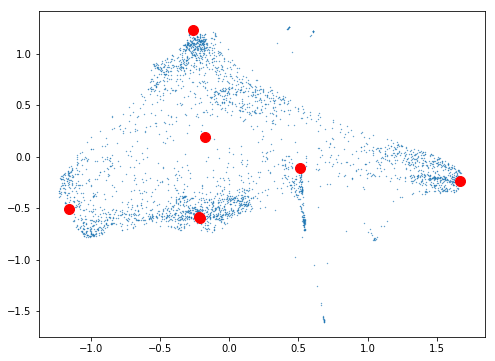

In [46]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.scatter(Y_phate_nu_3D[:-num_at,0], Y_phate_nu_3D[:-num_at,1], s=.1)
plt.scatter(Y_phate_nu_3D[-num_at:,0], Y_phate_nu_3D[-num_at:,1], s=100, c='r')
plt.show()
fig, ax = plt.subplots(1, figsize=(8,6))
plt.scatter(Y_phate_nu_3D[:-num_at,0], Y_phate_nu_3D[:-num_at,2], s=.1)
plt.scatter(Y_phate_nu_3D[-num_at:,0], Y_phate_nu_3D[-num_at:,2], s=100, c='r')
plt.show()

In [40]:
# project ATs from PCA to input space
ats_x = model.get_ats_x()
print(ats_x.shape)
ats_x = ats_x * sigma
ats_x_orig = ats_x @ U.T + X_mu;
print(ats_x_orig.shape)

(7, 25)
(7, 16014)


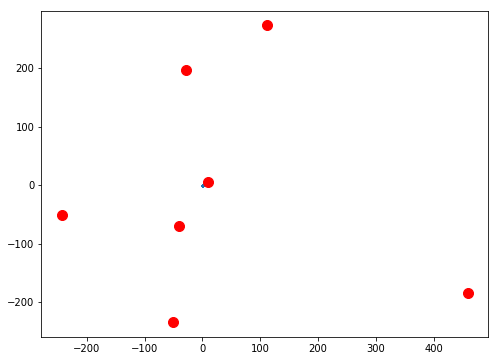

In [139]:
# PHATE with ATs projected in
data_at = model.data2at(data)
data_at_norm = data_at / np.sum(data_at)
Y_phate_ats = data_at.T @ Y_phate
fig, ax = plt.subplots(1, figsize=(8,6))
plt.scatter(Y_phate[:,0], Y_phate[:,1], s=.1)
plt.scatter(Y_phate_ats[:,0], Y_phate_ats[:,1], s=100, c='r')
plt.show()